# Per-Character Metric Comparison: Human vs LLM

This notebook compares individual character metrics between human players and their LLM counterparts. Unlike campaign-level analysis, this focuses on individual character contributions aggregated across all campaigns.

**Metrics included:**
- **DSI (Divergent Semantic Integration)**: Measures semantic diversity in text using BERT embeddings
- **Jaccard Similarity**: Measures vocabulary consistency across sessions (cross-session self-consistency)
- **Vocabulary Size**: Total unique words used by each character
- **Semantic Sequential Cohesion**: Measures how coherent a character's contributions are over time (post-to-post self-similarity)
- **Semantic Session Cohesion**: Measures within-session similarity for each character's messages (grouped into fixed-size chunks)

In [1]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from dnd_dynamics.analysis import data_loading as dl
from dnd_dynamics.analysis import metrics
from dnd_dynamics.analysis import plot_utils as pu

# Set up plotting style
plt.style.use('default')
plt.rcParams['figure.dpi'] = 100
plt.rcParams.update({'font.size': 8})

# Output directory
OUTPUT_DIR = Path('plots')
OUTPUT_DIR.mkdir(exist_ok=True)

Anthropic API key loaded
OpenAI API key loaded
Gemini API key loaded


# Configuration

In [2]:
# === CONFIGURATION ===

# Base campaign names to analyze
CAMPAIGN_BASE_NAMES = [
    '1262-firedeath-must-die-closed-play-by-post-open-ogg',
    '3135-the-head-of-the-serpent',
    '10391-guardians-of-gridori',
    '20049-age-of-death',
    '89221-banhaven-academy-year-1',
    '90630-firecat5s-dragon-of-icespire-peak',
    '7426-serpent-isle-private-campaign',
]

# LLM game filters
LLM_FILTER = {
    'model': ['gpt-4o', 'gemini-1.5-pro', 'claude-3-7-sonnet-latest'],
    'campaign_name': CAMPAIGN_BASE_NAMES,
    'include_player_personalities': [True, False],
    'year': 2025,
    'scratchpad': True,
}

# Category grouping - which metadata fields to group by for aggregation
CATEGORY_FIELDS = ['model', 'include_player_personalities']

# Analysis parameters
MESSAGES_PER_SESSION = 5
FORCE_REFRESH = False

# Data Loading

In [3]:
# === DATA LOADING ===

# Load human campaigns
dfs_human = dl.load_campaigns(
    CAMPAIGN_BASE_NAMES,
    messages_per_session=MESSAGES_PER_SESSION
)

# Load LLM campaigns with filtering
dfs_llm = dl.load_campaigns(
    'llm',
    messages_per_session=MESSAGES_PER_SESSION,
    filter_by=LLM_FILTER
)

# Combine DataFrames
dfs = {**dfs_human, **dfs_llm}

print(f"Loaded {len(dfs_human)} human campaigns, {len(dfs_llm)} LLM campaigns")
print(f"Total: {len(dfs)} campaigns")

Filter matched 42 campaigns
Loading 42 campaigns from /Users/annie/Code/Repositories/dnd-dynamics/data/llm-games/game-logs


Loading campaigns: 100%|██████████| 42/42 [00:02<00:00, 19.65it/s]

Loaded 42 campaigns (10,215 messages)
Loaded 7 human campaigns, 42 LLM campaigns
Total: 49 campaigns


# DSI Analysis

DSI (Divergent Semantic Integration) measures semantic diversity in text. The `by_player` field in DSI results contains per-character breakdowns that we'll use for this analysis.

In [4]:
# === DSI ANALYSIS ===

dsi_results = metrics.analyze_dsi(dfs, force_refresh=FORCE_REFRESH)

📁 Loaded 49 cached DSI results


# Extract Per-Character DSI Scores

The DSI metric calculates scores per "scene" (approximately 175 words). Each character has their own set of scene-level DSI scores stored in the `by_player` field.

In [5]:
def extract_character_dsi_scores(dsi_results, metric_type='scores'):
    """
    Extract per-character DSI data from DSI results.
    
    Args:
        dsi_results: Dict[campaign_id, MetricResult] from analyze_dsi()
        metric_type: 'scores' for all scene-level DSI scores (array),
                     'mean' for single mean_dsi value per character
    
    Returns:
        Dict[campaign_id, np.array] - pooled character scores per campaign
    """
    character_data = {}
    
    for campaign_id, result in dsi_results.items():
        if result is None or not result.by_player:
            character_data[campaign_id] = np.array([])
            continue
        
        campaign_scores = []
        for player_name, player_result in result.by_player.items():
            # Uncomment to skip DM/Dungeon Master
            # if 'dungeon master' in player_name.lower() or player_name.lower() == 'dm':
            #     continue
            
            if metric_type == 'scores':
                # Get all scene-level DSI scores for this character
                scores = player_result.series.get('dsi_scores', np.array([]))
                campaign_scores.extend(scores)
            elif metric_type == 'mean':
                # Get single mean DSI for this character
                mean_dsi = player_result.summary.get('mean_dsi', np.nan)
                if not np.isnan(mean_dsi):
                    campaign_scores.append(mean_dsi)
        
        character_data[campaign_id] = np.array(campaign_scores)
    
    return character_data


def aggregate_character_metric(character_data, campaign_names, categories, category_order):
    """
    Aggregate character-level data by category.
    
    Args:
        character_data: Dict[campaign_id, np.array] from extract_character_dsi_scores()
        campaign_names: List of all campaign names
        categories: Dict from categorize_campaigns()
        category_order: List specifying display order
    
    Returns:
        List of np.arrays, one per category (pooled across all campaigns in category)
    """
    name_to_data = {name: character_data.get(name, np.array([])) for name in campaign_names}
    
    result = []
    for cat in category_order:
        cat_names = categories.get(cat, [])
        if cat_names:
            cat_arrays = [name_to_data[n] for n in cat_names if n in name_to_data]
            # Filter out empty arrays before concatenating
            cat_arrays = [arr for arr in cat_arrays if len(arr) > 0]
            if cat_arrays:
                result.append(np.concatenate(cat_arrays))
            else:
                result.append(np.array([]))
        else:
            result.append(np.array([]))
    
    return result

# Categorize and Aggregate Data

In [6]:
# === CATEGORIZE CAMPAIGNS ===

campaign_names = list(dfs.keys())
categories = pu.categorize_campaigns(campaign_names, CATEGORY_FIELDS)

# Define category display order (must match format from categorize_campaigns)
CATEGORY_ORDER = [
    'human',
    'model:gemini-1.5-pro, include_player_personalities:False',
    'model:gemini-1.5-pro, include_player_personalities:True',
    'model:claude-3-7-sonnet-latest, include_player_personalities:False',
    'model:claude-3-7-sonnet-latest, include_player_personalities:True',
    'model:gpt-4o, include_player_personalities:False',
    'model:gpt-4o, include_player_personalities:True',
]

print("Campaign categories:")
for cat, names in categories.items():
    print(f"  {cat}: {len(names)} campaigns")

Campaign categories:
  human: 7 campaigns
  model:claude-3-7-sonnet-latest, include_player_personalities:False: 7 campaigns
  model:claude-3-7-sonnet-latest, include_player_personalities:True: 7 campaigns
  model:gemini-1.5-pro, include_player_personalities:False: 7 campaigns
  model:gemini-1.5-pro, include_player_personalities:True: 7 campaigns
  model:gpt-4o, include_player_personalities:False: 7 campaigns
  model:gpt-4o, include_player_personalities:True: 7 campaigns


In [7]:
# === EXTRACT AND AGGREGATE CHARACTER DSI ===

# Scene-level DSI scores (more granular)
character_dsi_data = extract_character_dsi_scores(dsi_results, metric_type='scores')
character_dsi_agg = aggregate_character_metric(character_dsi_data, campaign_names, categories, CATEGORY_ORDER)

# Mean DSI per character (one value per character)
character_mean_dsi_data = extract_character_dsi_scores(dsi_results, metric_type='mean')
character_mean_dsi_agg = aggregate_character_metric(character_mean_dsi_data, campaign_names, categories, CATEGORY_ORDER)

# Print aggregation summary
print("Character DSI aggregation summary:")
print(f"{'Category':<60} {'Scenes':>10} {'Characters':>12}")
print("-" * 84)
for i, cat in enumerate(CATEGORY_ORDER):
    print(f"{cat:<60} {len(character_dsi_agg[i]):>10} {len(character_mean_dsi_agg[i]):>12}")

Character DSI aggregation summary:
Category                                                         Scenes   Characters
------------------------------------------------------------------------------------
human                                                               652           42
model:gemini-1.5-pro, include_player_personalities:False            716           40
model:gemini-1.5-pro, include_player_personalities:True             835           40
model:claude-3-7-sonnet-latest, include_player_personalities:False       1137           40
model:claude-3-7-sonnet-latest, include_player_personalities:True       1167           40
model:gpt-4o, include_player_personalities:False                   1661           40
model:gpt-4o, include_player_personalities:True                    1675           40


# Visualization: Human vs LLM Character DSI

Each panel shows the human distribution (lighter) compared to one LLM condition (darker). This allows us to see how individual character DSI varies between human and LLM play.

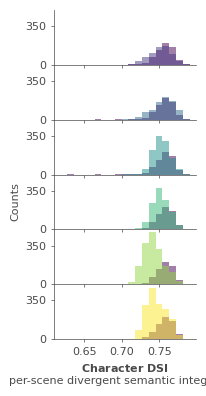

In [8]:
# === SCENE-LEVEL DSI COMPARISON ===
# Shows distribution of all individual scene DSI scores

pu.plot_comparison_histograms(
    character_dsi_agg,
    bins=20,
    log_bins=False,
    xlabel=r'$\mathbf{Character\ DSI}$' + '\nper-scene divergent semantic integration',
    figsize=(2.1, 4))
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig(OUTPUT_DIR / 'human_vs_llm_character_dsi_scenes.pdf', transparent=True)

# Jaccard Analysis & Vocabulary Size

The `by_player` field contains per-character metrics:
- **Jaccard similarity**: Cross-session vocabulary consistency (how similar is a player's vocabulary between different sessions?)
- **Vocabulary size**: Total unique words used by the character across the campaign

In [9]:
# === JACCARD ANALYSIS ===

jaccard_results = metrics.analyze_jaccard(dfs, force_refresh=FORCE_REFRESH)

📁 Loaded 49 cached jaccard results


In [ ]:
def extract_character_jaccard_scores(jaccard_results, metric_type='scores'):
    """
    Extract per-character Jaccard data from Jaccard results.
    
    Args:
        jaccard_results: Dict[campaign_id, MetricResult] from analyze_jaccard()
        metric_type: 'scores' for all session-pair Jaccard scores (array),
                     'mean' for single mean_jaccard value per character,
                     'vocab_size' for vocabulary size per character
    
    Returns:
        Dict[campaign_id, np.array] - pooled character scores per campaign
    """
    character_data = {}
    
    for campaign_id, result in jaccard_results.items():
        if result is None or not result.by_player:
            character_data[campaign_id] = np.array([])
            continue
        
        campaign_scores = []
        for player_name, player_result in result.by_player.items():
            # Uncomment to skip DM/Dungeon Master
            # if 'dungeon master' in player_name.lower() or player_name.lower() == 'dm':
            #     continue
            
            if metric_type == 'scores':
                scores = player_result.series.get('jaccard_session_pairs', np.array([]))
                campaign_scores.extend(scores)
            elif metric_type == 'mean':
                mean_jaccard = player_result.summary.get('mean_jaccard', np.nan)
                if not np.isnan(mean_jaccard):
                    campaign_scores.append(mean_jaccard)
            elif metric_type == 'vocab_size':
                vocab_size = player_result.summary.get('vocabulary_size', np.nan)
                if not np.isnan(vocab_size):
                    campaign_scores.append(vocab_size)
        
        character_data[campaign_id] = np.array(campaign_scores)
    
    return character_data


# Extract and aggregate character Jaccard data (series)
character_jaccard_data = extract_character_jaccard_scores(jaccard_results, metric_type='scores')
character_jaccard_agg = aggregate_character_metric(character_jaccard_data, campaign_names, categories, CATEGORY_ORDER)

# Extract and aggregate character Jaccard data (mean per character)
character_mean_jaccard_data = extract_character_jaccard_scores(jaccard_results, metric_type='mean')
character_mean_jaccard_agg = aggregate_character_metric(character_mean_jaccard_data, campaign_names, categories, CATEGORY_ORDER)

# Extract and aggregate vocabulary size per character
character_vocab_data = extract_character_jaccard_scores(jaccard_results, metric_type='vocab_size')
character_vocab_agg = aggregate_character_metric(character_vocab_data, campaign_names, categories, CATEGORY_ORDER)

# Print aggregation summary
print("Character Jaccard aggregation summary:")
print(f"{'Category':<60} {'Session Pairs':>14} {'Characters':>12}")
print("-" * 88)
for i, cat in enumerate(CATEGORY_ORDER):
    print(f"{cat:<60} {len(character_jaccard_agg[i]):>14} {len(character_mean_jaccard_agg[i]):>12}")

In [ ]:
# === JACCARD COMPARISON PLOT ===
# Shows distribution of cross-session vocabulary consistency per character

pu.plot_comparison_histograms(
    character_jaccard_agg,
    bins=20,
    log_bins=False,
    xlabel=r'$\mathbf{Character\ Jaccard}$' + '\ncross-session vocabulary consistency',
    figsize=(2.1, 4))
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig(OUTPUT_DIR / 'human_vs_llm_character_jaccard.pdf', transparent=True)

In [ ]:
# === JACCARD MEAN PER CHARACTER PLOT ===
# Shows distribution of mean Jaccard per character (one value per character)

pu.plot_comparison_histograms(
    character_mean_jaccard_agg,
    bins=20,
    log_bins=False,
    xlabel=r'$\mathbf{Character\ Mean\ Jaccard}$' + '\nmean cross-session consistency per character',
    figsize=(2.1, 4))
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig(OUTPUT_DIR / 'human_vs_llm_character_mean_jaccard.pdf', transparent=True)

In [ ]:
# === VOCABULARY SIZE PER CHARACTER PLOT ===
# Shows distribution of total unique words per character

pu.plot_comparison_histograms(
    character_vocab_agg,
    bins=20,
    log_bins=False,
    xlabel=r'$\mathbf{Character\ Vocabulary\ Size}$' + '\ntotal unique words',
    figsize=(2.1, 4))
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig(OUTPUT_DIR / 'human_vs_llm_character_vocab_size.pdf', transparent=True)

# Semantic Cohesion Analysis

Semantic cohesion measures how similar posts are using sentence embeddings. The `by_player` field contains two per-character metrics:

- **Sequential Cohesion**: Similarity between consecutive posts (comparing each post to the previous one, ignoring other players' posts in between)
- **Session Cohesion**: Within-chunk pairwise similarity (grouping the player's messages into fixed-size chunks and measuring internal consistency)

In [ ]:
# === SEMANTIC ANALYSIS ===

semantic_results = metrics.analyze_semantic(dfs, force_refresh=FORCE_REFRESH)

Analyzing semantic:   2%|▏         | 1/49 [00:00<00:06,  7.62it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_1d856382f77e46111cc04a9ff0553a08.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_9ca18b8202b6f2afd0906bff88a41065.pkl


Analyzing semantic:  10%|█         | 5/49 [00:00<00:03, 13.88it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_4ea0d19639c24590e3d491e67de86572.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_f2029c1228038bbef780bac0fb5e9915.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_aaaf588d824ca5f69d135624f0f55b37.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_45d4faf4bf8a3dd90f795497637fff24.pkl


Analyzing semantic:  16%|█▋        | 8/49 [00:00<00:02, 15.60it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_3c00201e35c6b3a16a9de46b4efdb55a.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_fab16e9ea54056f2532124420f6f2b9f.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_a0e4258326051cdfa284b41107dee834.pkl


Analyzing semantic:  24%|██▍       | 12/49 [00:00<00:02, 14.41it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_76d2911ac57fdc46c526db3b707b8b87.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_683342be4a2b0a8ee1b1c9e2a4c02857.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_87e1e9f5c8da68b20be3578609f01858.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_8518f4cf81dc50f5dd2a98c6d7769778.pkl


Analyzing semantic:  29%|██▊       | 14/49 [00:00<00:02, 14.80it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_9ecea4edb43bcf3a66246b62a9aa2b92.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_81c8fb3aaf705a6cb691280eafec4ceb.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_27fb31b7b3c8c3ff8d088f9ea99c15d9.pkl


Analyzing semantic:  33%|███▎      | 16/49 [00:01<00:02, 12.95it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_04a594a180c77139133dd4255d20e7c7.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_b85383fc3517e51147585c46aa99a547.pkl


Analyzing semantic:  41%|████      | 20/49 [00:01<00:02, 10.88it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_4e2d3665b5f0a1a422f3ae7646102d77.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_c42fc1151185464f368a5c0e5706d9e1.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_d57704ec01cce04a32f156fdf2aefcd8.pkl


Analyzing semantic:  47%|████▋     | 23/49 [00:01<00:01, 13.54it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_73bbeb4b89caae58b4e89f4a3e438797.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_99dc3ef4d724518a2f7d814c3089a790.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_3b61d9b39d81227ce114f65dff4d7fb4.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_1cf90d5dcc39ecf51da412287d56ff81.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_28a0b4ae626d742735bc4bb5669df97f.pkl


Analyzing semantic:  57%|█████▋    | 28/49 [00:02<00:01, 14.45it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_4b5559403dddc408428a32b736e8f72e.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_bec0e5cd8b594f159ff01de56e87ee03.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_d8a7e1d14b86d5eeac5da791f8836ce1.pkl


Analyzing semantic:  67%|██████▋   | 33/49 [00:02<00:00, 17.02it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_0528f96570fbd0b93fc58eb7250091b8.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_da2e35d002f3fa1b5930300616c7be3d.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_8727bebd419fc83b0cf31f22b2885d0d.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_0bc9544f3375d671ce46040036f98f67.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_21c04da6c037699d6cb0978773b8077b.pkl


Analyzing semantic:  78%|███████▊  | 38/49 [00:02<00:00, 22.93it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_4c8d58198f0e99029fd698ae0d5a8e01.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_45469fff62410d893c3ea66709e62d17.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_bb8f29f33f00ee799ffa1766f31c8b38.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_8c8ccb54b6f05365f085ab9866a1c19b.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_1941af12dcb74de0fb4e0e8dc8fe2934.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_f28a46e04b0fff1941b243e88a2a960f.pkl


Analyzing semantic:  84%|████████▎ | 41/49 [00:02<00:00, 18.67it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_f55ecbd08816a360ed788ae6a7ed4abc.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_3ca90c5701e27093518cc714e98de2a6.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_dcc52f404e176ca4993c7254944bbc0b.pkl


Analyzing semantic:  94%|█████████▍| 46/49 [00:03<00:00, 17.18it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_7f74cad54235f8a177dbb7436820b856.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_b29042349dd88596d8955d02716035a9.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_a8c876ba2da6821518f4b2e9380855a2.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_5decd7fa17edcc497bef346a76a72bac.pkl


Analyzing semantic: 100%|██████████| 49/49 [00:03<00:00, 15.20it/s]

Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_8cc36964f38e946389bc9b189b289c46.pkl
Loading embeddings from cache: /Users/annie/Code/Repositories/dnd-dynamics/data/processed/embeddings_cache/embeddings_863358860a19fa026e25f1bda07aa8de.pkl
💾 Saved 49 semantic results to cache


In [13]:
def extract_character_semantic_scores(semantic_results, series_key='sequential_cohesion'):
    """
    Extract per-character semantic cohesion data from semantic results.
    
    Args:
        semantic_results: Dict[campaign_id, MetricResult] from analyze_semantic()
        series_key: Key in series dict ('sequential_cohesion' or 'session_cohesion')
    
    Returns:
        Dict[campaign_id, np.array] - pooled character scores per campaign
    """
    character_data = {}
    
    for campaign_id, result in semantic_results.items():
        if result is None or not result.by_player:
            character_data[campaign_id] = np.array([])
            continue
        
        campaign_scores = []
        for player_name, player_result in result.by_player.items():
            # Uncomment to skip DM/Dungeon Master
            # if 'dungeon master' in player_name.lower() or player_name.lower() == 'dm':
            #     continue
            
            scores = player_result.series.get(series_key, np.array([]))
            campaign_scores.extend(scores)
        
        character_data[campaign_id] = np.array(campaign_scores)
    
    return character_data


# === SEQUENTIAL COHESION ===
character_seq_data = extract_character_semantic_scores(semantic_results, series_key='sequential_cohesion')
character_seq_agg = aggregate_character_metric(character_seq_data, campaign_names, categories, CATEGORY_ORDER)

# === SESSION COHESION ===
character_sess_data = extract_character_semantic_scores(semantic_results, series_key='session_cohesion')
character_sess_agg = aggregate_character_metric(character_sess_data, campaign_names, categories, CATEGORY_ORDER)

# Print aggregation summary
print("Character Semantic Cohesion aggregation summary:")
print(f"{'Category':<60} {'Sequential':>12} {'Session':>12}")
print("-" * 86)
for i, cat in enumerate(CATEGORY_ORDER):
    print(f"{cat:<60} {len(character_seq_agg[i]):>12} {len(character_sess_agg[i]):>12}")

Character Semantic Cohesion aggregation summary:
Category                                                       Sequential      Session
--------------------------------------------------------------------------------------
human                                                                1776          372
model:gemini-1.5-pro, include_player_personalities:False             1771          371
model:gemini-1.5-pro, include_player_personalities:True              1771          371
model:claude-3-7-sonnet-latest, include_player_personalities:False         1409          298
model:claude-3-7-sonnet-latest, include_player_personalities:True         1478          314
model:gpt-4o, include_player_personalities:False                     1771          371
model:gpt-4o, include_player_personalities:True                      1771          371


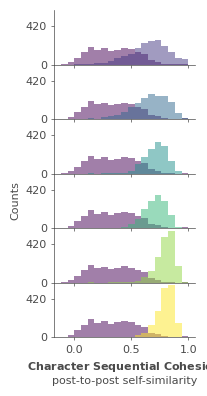

In [16]:
# === SEQUENTIAL COHESION COMPARISON PLOT ===
# Shows distribution of post-to-post similarity per character

pu.plot_comparison_histograms(
    character_seq_agg,
    bins=20,
    log_bins=False,
    xlabel=r'$\mathbf{Character\ Sequential\ Cohesion}$' + '\npost-to-post self-similarity',
    figsize=(2.1, 4))
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig(OUTPUT_DIR / 'human_vs_llm_character_sequential_cohesion.pdf', transparent=True)

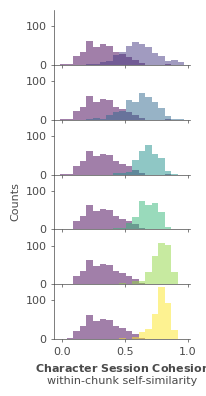

In [15]:
# === SESSION COHESION COMPARISON PLOT ===
# Shows distribution of within-chunk pairwise similarity per character

pu.plot_comparison_histograms(
    character_sess_agg,
    bins=20,
    log_bins=False,
    xlabel=r'$\mathbf{Character\ Session\ Cohesion}$' + '\nwithin-chunk self-similarity',
    figsize=(2.1, 4))
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig(OUTPUT_DIR / 'human_vs_llm_character_session_cohesion.pdf', transparent=True)